In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install kaggle

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [4]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0
 98% 215M/219M [00:03<00:00, 68.8MB/s]
100% 219M/219M [00:03<00:00, 64.6MB/s]


In [5]:
!unzip /content/rice-image-dataset.zip -d /content/rice-image-dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: /content/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: /content/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: /content/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: /content/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: /content/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: /content/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: /content/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: /content/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: /content/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: /content/

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import transforms, utils, datasets, models
from torch.autograd import Variable
from keras.optimizers import Adam
import glob
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pathlib

In [7]:
path = pathlib.Path("/content/rice-image-dataset/Rice_Image_Dataset")

In [8]:
# Listing Image Files in Specific Folders and Combining All the Image Lists
arborio = list(path.glob('Arborio/*'))
basmati = list(path.glob('Basmati/*'))
ipsala = list(path.glob('Ipsala/*'))
jasmine = list(path.glob('Jasmine/*'))
karacadag = list(path.glob('Karacadag/*'))

total_list=arborio + basmati + ipsala + jasmine + karacadag

In [9]:
# Image Transformation Pipeline
data_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((100, 100)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
    ]
)

model_dataset =  datasets.ImageFolder(path, transform=data_transform)

In [10]:
# Defining Batch Size and Dataset Splitting into Train, Validation, and Test Sets
BATCH_SIZE=256

train_count = int(0.7 * len(total_list))
valid_count = int(0.2 * len(total_list))
test_count = len(total_list) - train_count - valid_count

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(model_dataset, (train_count, valid_count, test_count))

# Creating DataLoaders
train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataset_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

dataloaders = {'train': train_dataset_loader, 'val': valid_dataset_loader, 'test': test_dataset_loader}

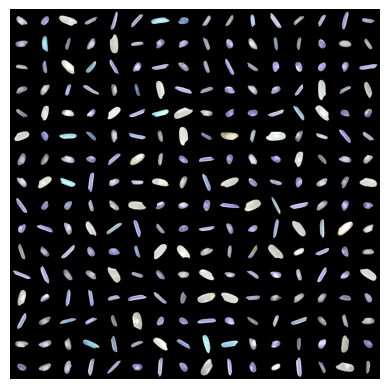

In [11]:
# Visualizing the train dataset
for item in train_dataset_loader:
  image, _ = item
  plt.imshow(make_grid(image, nrow=16).permute(1, 2, 0))
  plt.axis('off')
  plt.show()
  break

In [12]:
# Defining the CNN Model and the Forward Pass

class CustomizedConvNet(nn.Module):
  def __init__(self, number_of_classes):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, padding=1, kernel_size=3)
    self.bn1 = nn.BatchNorm2d(num_features=12)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2)

    self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, padding=1, kernel_size=3)
    self.bn2 = nn.BatchNorm2d(num_features=20)
    self.relu2 = nn.ReLU()

    self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, padding=1, kernel_size=3)
    self.bn3 = nn.BatchNorm2d(num_features=32)
    self.relu3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size=2)

    self.fc1 = nn.Linear(32*25*25, 5)

  def forward(self, Input):

    output = self.conv1(Input)
    output = self.bn1(output)
    output = self.relu1(output)
    output = self.pool1(output)

    output = self.conv2(output)
    output = self.bn2(output)
    output = self.relu2(output)

    output = self.conv3(output)
    output = self.bn3(output)
    output = self.relu3(output)
    output = self.pool3(output)

    output = torch.flatten(output, 1)
    output = output.view(-1, 32*25*25)
    output = self.fc1(output)

    return output

In [15]:
model = CustomizedConvNet(5)
device='cuda'
model = model.to(device)
model

CustomizedConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=20000, out_features=5, bias=True)
)

In [16]:
# Defining Accuracy, Validation Step, Training Loop
def accuracy(pred, label):
    _, out = torch.max(pred, dim=1)
    return torch.tensor(torch.sum(out == label).item()/len(pred))

def validation_step(valid_dl, model, loss_fn):
    for image, label in valid_dl:
        out = model(image)
        loss = loss_fn(out, label)
        acc = accuracy(out, label)
        return {"val_loss": loss, "val_acc": acc}

def fit_to_model(train_dl, valid_dl, epochs, optimizer, loss_fn, model):
    history = []
    for epoch in range(epochs):
        for image, label in train_dl:
            out = model(image)
            loss = loss_fn(out, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


        val = validation_step(valid_dl, model, loss_fn)
        print(f"Epoch [{epoch}/{epochs}] => loss: {loss}, val_loss: {val['val_loss']}, val_acc: {val['val_acc']}")
        history.append({"loss": loss,
                        "val_loss": val['val_loss'],
                        "val_acc": val['val_acc']
                       })
    return history

# Function to Transfer Data to Device (GPU)
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)


In [17]:
# Instantiating Data Loaders with Device Transfer
train_dataset_loader= DeviceDataLoader(train_dataset_loader, device)
valid_dataset_loader = DeviceDataLoader(valid_dataset_loader, device)

In [18]:
# Loss Function, Optimizer, and Training
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 5
history = fit_to_model(train_dataset_loader, valid_dataset_loader, epochs, optimizer, Loss, model)

Epoch [0/5] => loss: 0.025732267647981644, val_loss: 0.04985692724585533, val_acc: 0.984375
Epoch [1/5] => loss: 0.0026006889529526234, val_loss: 0.02483329176902771, val_acc: 0.98828125
Epoch [2/5] => loss: 0.0005733735160902143, val_loss: 0.024833986535668373, val_acc: 0.98828125
Epoch [3/5] => loss: 0.005536750890314579, val_loss: 0.013477442786097527, val_acc: 0.99609375
Epoch [4/5] => loss: 0.008167656138539314, val_loss: 0.027377808466553688, val_acc: 0.98828125


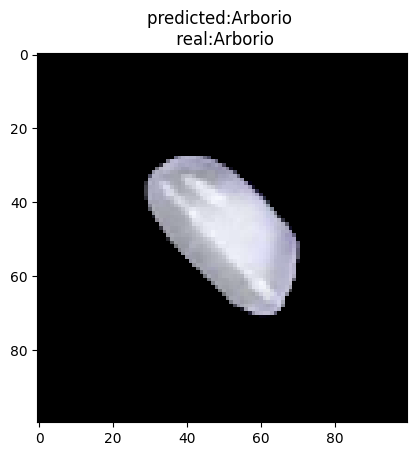

In [19]:
# Visualizing the Results
model = model.cpu()
with torch.no_grad():

    for img,label in test_dataset_loader:
        imgs = img[100]
        labels = label[100]
        output_model = imgs.unsqueeze(0)
        output_model = model(output_model)
        index = output_model.argmax()
        imgs = torch.permute(imgs,(1,2,0))
        plt.imshow(imgs)
        plt.title(f"predicted:{ model_dataset.classes[index]} \n real:{ model_dataset.classes[labels]}")
        break